In [1]:
setwd('/Users/alexis/IEHS Dropbox/Rager Lab/Alexis_Payton/1_Compartment_Analysis/Expt1.5_Baseline Cluster Analyses/Heat Map Input')
Output = ('/Users/alexis/IEHS Dropbox/Rager Lab/Alexis_Payton/1_Compartment_Analysis/Expt1.5_Baseline Cluster Analyses/Heat Map Output')
cur_date = "050821"

library(readxl)
library(dplyr)
library(tidyverse)
require(reshape2)
library(patchwork)

#reading in file
eigencytokines_NLF = read_csv("eigencytokines_NLF.csv") %>%
    rename(SubjectID = X1)
NLF_clus <- data.frame(read_excel("011921NLF_cluster_assignments.xlsx")) %>%
    rename(Protein = Cytokine)
cytokines <- data.frame(read_excel("CytokineData_102920.xlsx", sheet = 2))
eigenvector_weights = read_csv("042121_eigenvector_weights.csv") %>%
    filter(Dataset == 'Original', Compartment == 'NLF')


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.0.6     ✔ stringr 1.4.0
✔ tidyr   1.1.2     ✔ forcats 0.5.1
✔ readr   1.4.0     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: reshape2


Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths


Warning message:
“Missing column names filled in: 'X1' [1]”

── Column specification ────────────────────────────────────────────────────────
cols(
  X1 = col_character(),
  ClusterA = col_double(),
  ClusterB = col_double(),
  ClusterC = col_double()
)



── Column specification ───────────

In [2]:
#for the eigencytokines renaming the value to Conc_pslog2 is a bit misleading, but I did it to allow the full join 
#to work
#renaming cluster to name to make the final df
# eigencytokines df and splitting by cluster
eigencytokines_NLF = reshape2::melt(eigencytokines_NLF, variable = "Name", value.name = "Conc_pslog2") %>%
    group_by(Name) %>%
    group_split

eigencytokines_NLF_ClusterA = eigencytokines_NLF[[1]]
eigencytokines_NLF_ClusterB = eigencytokines_NLF[[2]]
eigencytokines_NLF_ClusterC = eigencytokines_NLF[[3]]
head(eigencytokines_NLF_ClusterC)

Using SubjectID as id variables



SubjectID,Name,Conc_pslog2
<chr>,<fct>,<dbl>
NS_1,ClusterC,0.1843548
NS_10,ClusterC,-0.3710065
NS_11,ClusterC,-0.2719736
NS_12,ClusterC,-0.3686111
NS_13,ClusterC,0.1487870
NS_14,ClusterC,0.2719736


In [3]:
#cytokines df that specifies the cluster they correspond to and splitting by those clusters
cytokines_df = full_join(cytokines, NLF_clus) %>%
    filter(Compartment == 'NLF', Group == 'NS') %>%
    select(SubjectID, Cluster, Protein, Conc_pslog2) %>%
    #renaming protein to name to make the final df
    rename(Name = Protein) %>%
    group_by(Cluster) %>%
    group_split

cytokines_ClusterA = cytokines_df[[1]] %>% 
    #needed to scale to be on the same scale as the eigencytokines
    mutate(Conc_pslog2 = scale(Conc_pslog2)) %>%
    select(-Cluster)
cytokines_ClusterB = cytokines_df[[2]] %>% 
    mutate(Conc_pslog2 = scale(Conc_pslog2)) %>%
    select(-Cluster)
cytokines_ClusterC = cytokines_df[[3]] %>% 
    mutate(Conc_pslog2 = scale(Conc_pslog2)) %>%
    select(-Cluster)
head(cytokines_ClusterC)

Joining, by = "Protein"



SubjectID,Name,Conc_pslog2
<chr>,<chr>,"<dbl[,1]>"
NS_1,IL8,0.2229867
NS_1,IP10,-0.5286079
NS_1,Fractalkine,0.7039617
NS_1,MIG,0.7372874
NS_2,IL8,-0.5292749
NS_2,IP10,-1.6496864


In [4]:
#obtaining average protein concentrations grouped by compartment and saving the order into a vector for heat map
ordered_df = inner_join(cytokines, NLF_clus) %>%
    filter(Compartment == 'NLF', Group == 'NS') %>%
    select(SubjectID, Cluster, Protein, Conc_pslog2) %>%
    #renaming protein to name to make the final df
    rename(Name = Protein) %>%
    group_by(Cluster, Name) %>%
    summarize(Avg_Conc = mean(Conc_pslog2)) %>%
    arrange(Avg_Conc)
ordered_avg_cytokines = ordered_df$Name
ordered_avg_cytokines

Joining, by = "Protein"

`summarise()` has grouped output by 'Cluster'. You can override using the `.groups` argument.



[1] "IL4"         "IL10"        "IL12p70"     "IFNg"        "TNFa"       
 [6] "IL17D"       "IL6"         "IL13"        "TARC"        "IL1b"       
[11] "IL17B"       "MIP1b"       "MIP1a"       "ITAC"        "Eotaxin3"   
[16] "Eotaxin"     "MCP1"        "IP10"        "MIG"         "IL8"        
[21] "Fractalkine"

In [5]:
#getting subject id's ordered by avg concentrations
ordered_df = inner_join(cytokines, NLF_clus) %>%
    filter(Compartment == 'NLF', Group == 'NS') %>%
    select(SubjectID, Cluster, Protein, Conc_pslog2) %>%
    #renaming protein to name to make the final df
    rename(Name = Protein) %>%
    group_by(SubjectID) %>%
    summarize(Avg_Conc = mean(Conc_pslog2)) %>%
    arrange(Avg_Conc)
ordered_avg_subject_ids = ordered_df$SubjectID
ordered_avg_subject_ids

Joining, by = "Protein"



[1] "NS_2"  "NS_6"  "NS_11" "NS_3"  "NS_9"  "NS_4"  "NS_1"  "NS_12" "NS_5" 
[10] "NS_10" "NS_7"  "NS_13" "NS_14" "NS_8"

In [6]:
#creating final df for each cluster
ClusterA_df = full_join(eigencytokines_NLF_ClusterA, cytokines_ClusterA)
ClusterB_df = full_join(eigencytokines_NLF_ClusterB, cytokines_ClusterB)
ClusterC_df = full_join(eigencytokines_NLF_ClusterC, cytokines_ClusterC)
final_df = data.frame(rbind(ClusterA_df, ClusterB_df, ClusterC_df)) %>%
    #creating a space within the cluster names
    mutate(Name = ifelse(Name == "ClusterA", "Cluster A", 
           ifelse(Name == "ClusterB", "Cluster B",
           ifelse(Name == "ClusterC", "Cluster C", Name))))
head(final_df)

Joining, by = c("SubjectID", "Name", "Conc_pslog2")

Joining, by = c("SubjectID", "Name", "Conc_pslog2")

Joining, by = c("SubjectID", "Name", "Conc_pslog2")



,SubjectID,Name,Conc_pslog2
,<chr>,<chr>,"<dbl[,1]>"
1,NS_1,Cluster A,0.2501533
2,NS_10,Cluster A,0.3117699
3,NS_11,Cluster A,0.2012847
4,NS_12,Cluster A,0.2340955
5,NS_13,Cluster A,0.2601693
6,NS_14,Cluster A,0.2687377


# Heat Map

Visualizes eigencytokines and their corresponding cytokine concentrations ordered by average cytokine concentration within each cluster. 

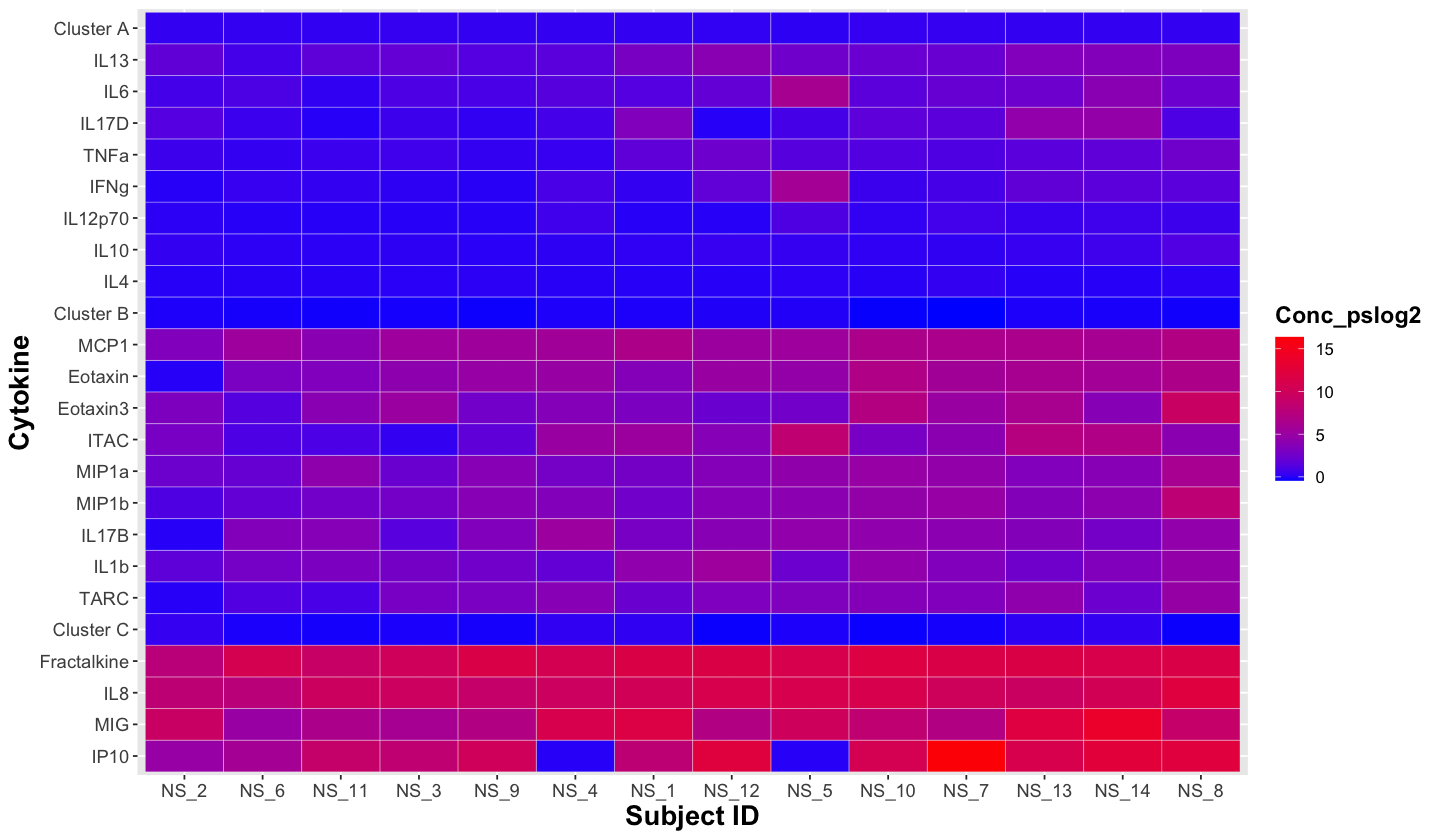

In [22]:
options(repr.plot.width=12, repr.plot.height=7) #changing size
#without scaling
#subject ids ordered alphabetically
# subject_ids = factor(final_df$SubjectID, levels = c("NS_1", "NS_2", "NS_3", "NS_4", "NS_5", "NS_6", "NS_7", 
#                                                     "NS_8", "NS_9", "NS_10", "NS_11", "NS_12", "NS_13", "NS_14"))
#subject ids ordered by avg cytokine conc
subject_ids = factor(final_df$SubjectID, levels = ordered_avg_subject_ids)
#perhaps change the name
Cytokine = factor(final_df$Name, levels = c('IP10','MIG','IL8','Fractalkine', "Cluster C", 'TARC','IL1b','IL17B',
                                            'MIP1b','MIP1a','ITAC','Eotaxin3','Eotaxin','MCP1', "Cluster B",'IL4',
                                            'IL10','IL12p70','IFNg','TNFa','IL17D','IL6','IL13', "Cluster A"))

nonscaled_heat_map = ggplot(data = final_df, aes(x = subject_ids, y = Cytokine, fill = Conc_pslog2)) + 
  geom_tile(color = "white") + 
  scale_fill_gradient(low = 'blue', high = 'red') + 

theme(axis.text = element_text(size = 11), #changing size of x axis labels
        axis.title = element_text(face = "bold", size = rel(1.5)), #changes axis titles
        legend.title = element_text(face = 'bold', size = 14), #changes legend title
        legend.text = element_text(size = 10))+ #changes legend text

labs(x = "Subject ID", legend = "Value")

nonscaled_heat_map

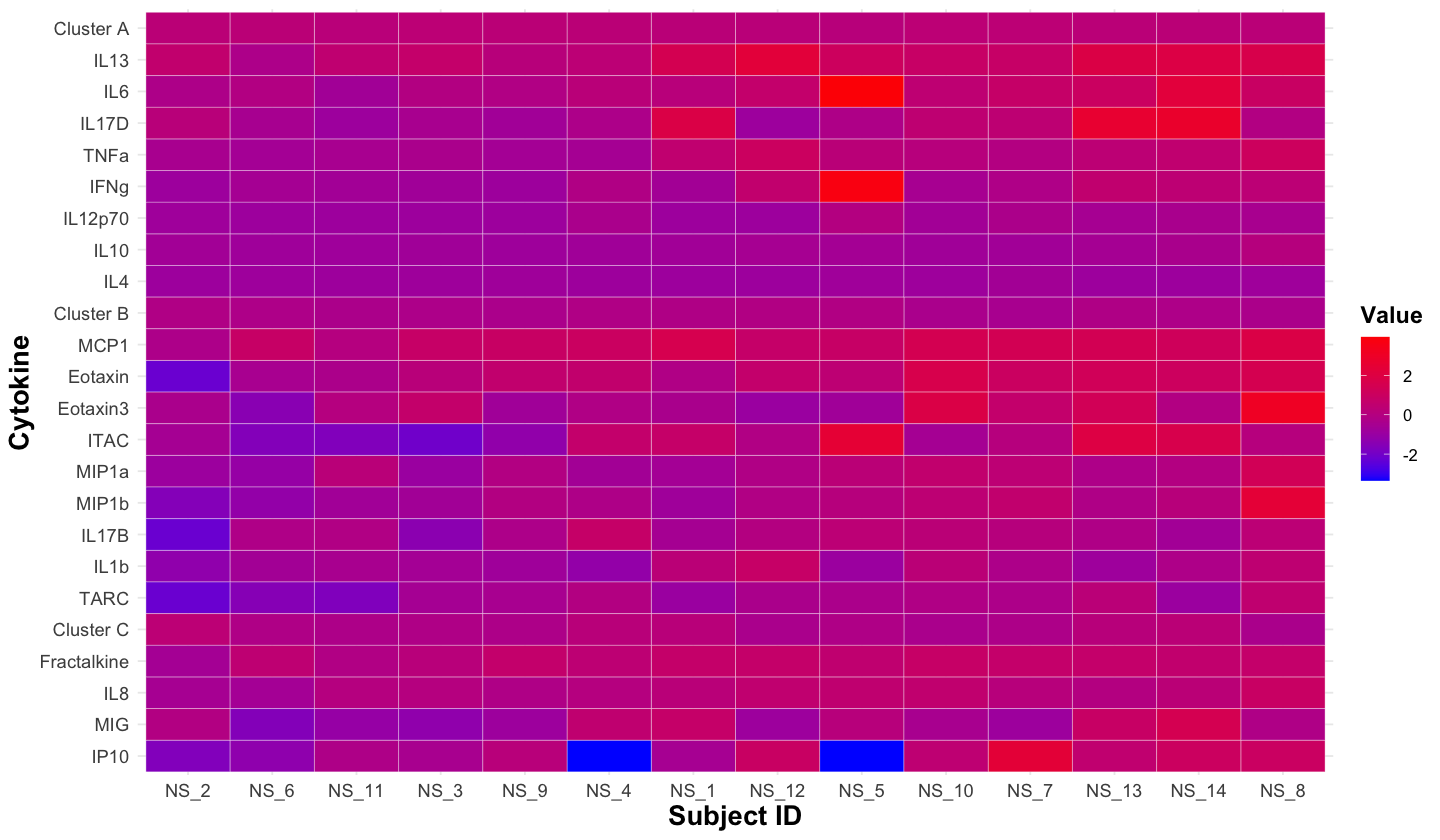

In [36]:
options(repr.plot.width=12, repr.plot.height=7) #changing size
#with scaling
#subject ids ordered alphabetically
# subject_ids = factor(final_df$SubjectID, levels = c("NS_1", "NS_2", "NS_3", "NS_4", "NS_5", "NS_6", "NS_7", 
#                                                        "NS_8", "NS_9", "NS_10", "NS_11", "NS_12", "NS_13", "NS_14"))
#subject ids ordered by avg cytokine conc
subject_ids = factor(final_df$SubjectID, levels = ordered_avg_subject_ids)
#perhaps change the name
Cytokine_ = factor(final_df$Name, levels = c('IP10','MIG','IL8','Fractalkine', "Cluster C", 'TARC','IL1b','IL17B',
                                            'MIP1b','MIP1a','ITAC','Eotaxin3','Eotaxin','MCP1', "Cluster B",'IL4',
                                            'IL10','IL12p70','IFNg','TNFa','IL17D','IL6','IL13', "Cluster A"))

scaled_heat_map = ggplot(data = final_df, aes(x = subject_ids, y = Cytokine_, fill = Conc_pslog2)) + 
  geom_tile(color = "white") + 
  scale_fill_gradient(low = 'blue', high = 'red') + 

  theme_minimal() +

  theme(axis.text = element_text(size = 11), #changing size of x axis labels
        axis.title = element_text(face = "bold", size = rel(1.5)), #changes axis titles
        legend.title = element_text(face = 'bold', size = 14), #changes legend title
        legend.text = element_text(size = 10)) + #changes legend text

  labs(x = "Subject ID", y = "Cytokine", fill = "Value")

scaled_heat_map

Now adding in the eigenvector weights.

In [8]:
head(eigenvector_weights)

Protein,Cluster,Weight,Compartment,Dataset
<chr>,<chr>,<dbl>,<chr>,<chr>
Eotaxin,Cluster A,2.2520806,NLF,Original
Eotaxin3,Cluster A,0.9517359,NLF,Original
IL17B,Cluster A,-1.1148861,NLF,Original
IL1b,Cluster A,-1.5890570,NLF,Original
ITAC,Cluster A,-1.3015929,NLF,Original
MCP1,Cluster A,4.7793969,NLF,Original


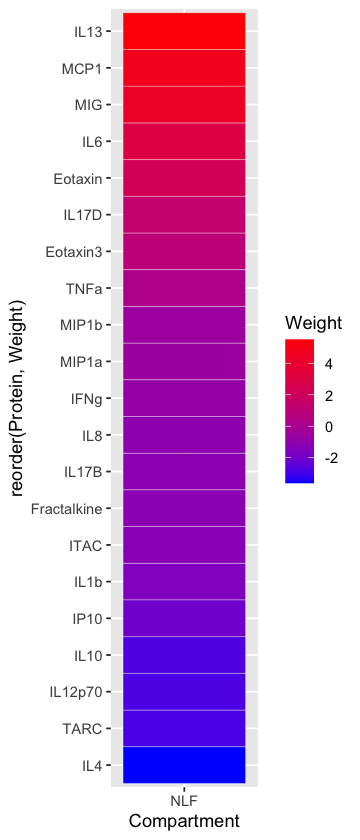

In [9]:
#this is nice, but I'll reorder the proteins based on the clusters
#also need to add in dummy variables for eigencytokines
options(repr.plot.width=3, repr.plot.height=7) #changing size
ggplot(data = eigenvector_weights, aes(x = Compartment, y = reorder(Protein, Weight), fill = Weight)) + 
  geom_tile(color = "white") + 
  scale_fill_gradient(low = 'blue', high = 'red')

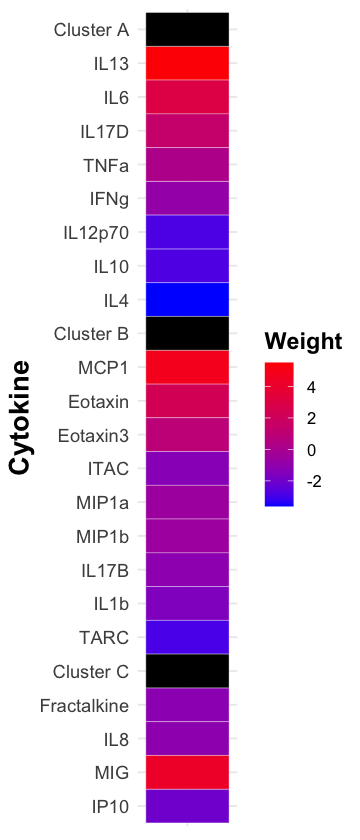

In [35]:
#adding in dummy variables for eigencytokines so the heat maps match
weights_2 = rbind(eigenvector_weights %>% select(-Dataset, -Cluster),
    data.frame(Protein = unique(eigenvector_weights$Cluster), Weight = c(NA, NA, NA), 
               Compartment = c("NLF", "NLF", "NLF")))
              
options(repr.plot.width=3, repr.plot.height=7) #changing size
Cytokine = factor(weights_2$Protein, levels = c('IP10','MIG','IL8','Fractalkine', "Cluster C", 'TARC','IL1b','IL17B',
                                            'MIP1b','MIP1a','ITAC','Eotaxin3','Eotaxin','MCP1', "Cluster B",'IL4',
                                            'IL10','IL12p70','IFNg','TNFa','IL17D','IL6','IL13', "Cluster A"))
weights_heat_map = ggplot(data = weights_2, aes(x = Compartment, y = Cytokine, fill = Weight)) + 
  geom_tile(color = "white") +  
    
  theme_minimal() + 
  theme(axis.text = element_text(size = 11), #changing size of x axis labels
        axis.title = element_text(face = "bold", size = rel(1.5)), #changes axis titles
        legend.title = element_text(face = 'bold', size = 14), #changes legend title
        legend.text = element_text(size = 10), #changes legend text
        axis.text.x = element_blank(), # removes x axis text
        axis.ticks.x = element_blank(), #removes x axis ticks
        axis.title.x = element_blank()) + #removes x axis title

  scale_fill_gradient(low = 'blue', high = 'red', na.value = "black")

weights_heat_map

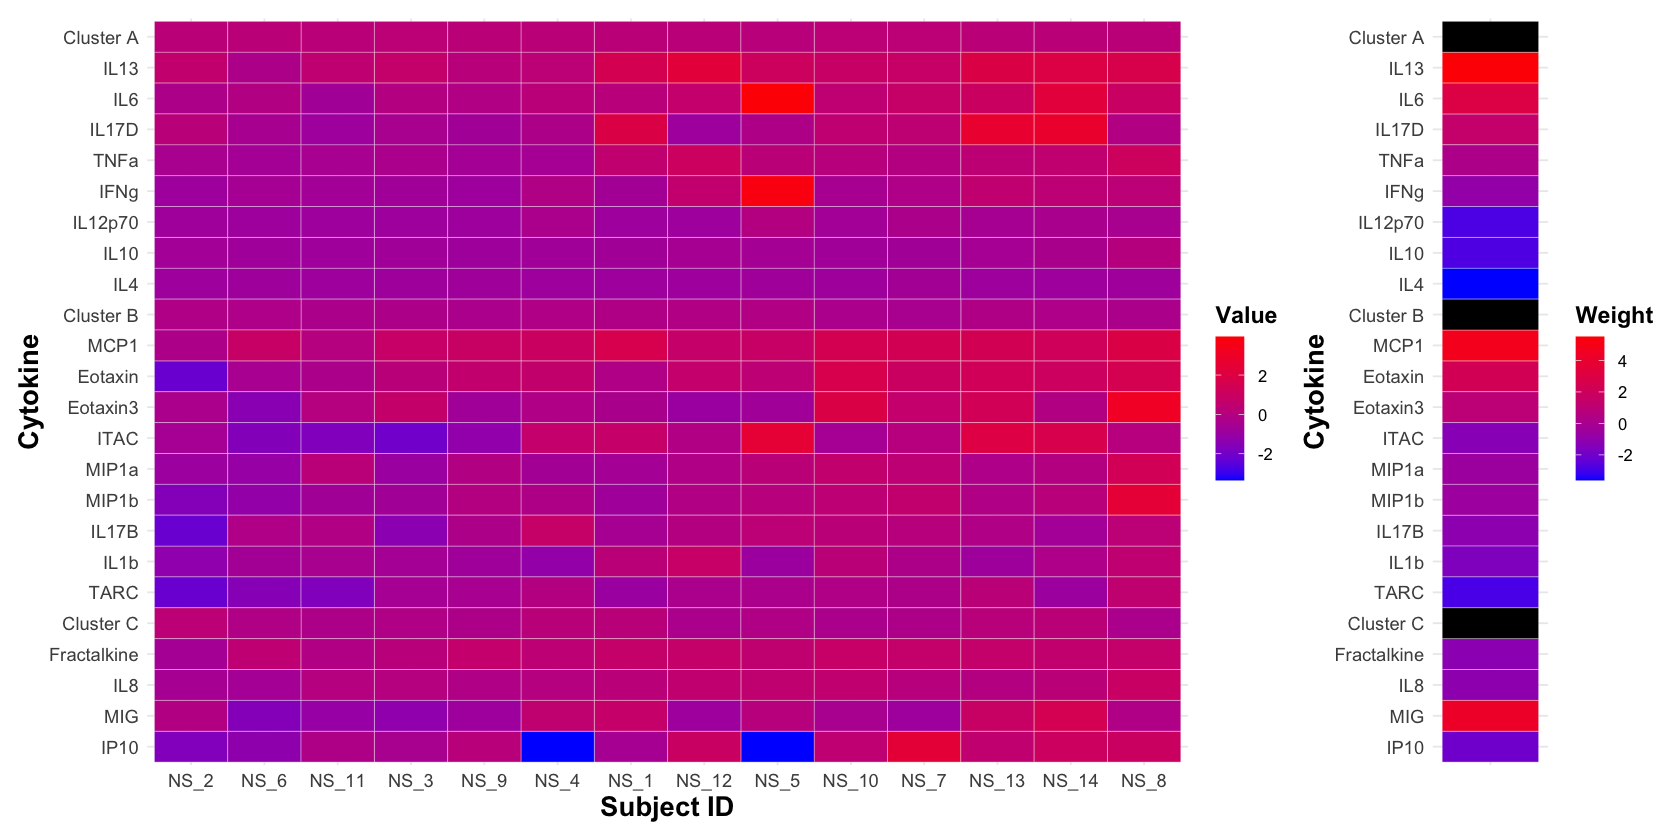

In [45]:
#putting everything together
options(repr.plot.width=14, repr.plot.height=7) #changing size
final_image = scaled_heat_map + weights_heat_map + plot_layout(width = c(9, 1))
final_image

In [47]:
ggsave(final_image, 
       filename = 'Heat Map.pdf',
       path = Output,
       width = 14, height = 7)